In [261]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from pathlib import Path
import numpy as np

Lê o caminho do csv contendo os resultandos e as colunas. 

In [262]:
CSV_PATH = Path("results/run_logs.csv")
COLS = ["modo","num_processos","tempo_clock","tempo_cpu",
        "tempo_comunicacao","tempo_total","timestamp","notas"]

Lê o csv e converte colunas númericas e de tempo. 

In [263]:
def ler_csv(caminho: Path, cols: list[str]) -> pd.DataFrame:
    df = pd.read_csv(caminho, names=cols)
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    for c in ("tempo_clock", "num_processos"):
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

*Cálculos*

Calcula o speedup do linear e do paralelo local e classifica o tipo. 
Baseado no csv e com o tempo linear calculado manualmente para as matrizes 4096x4096. 

    T1:
    TP:

In [264]:
def speedupN(T1, Tp):
    """Speedup básico: S = T1 / Tp."""
    return (T1 / Tp) if (Tp and Tp > 0) else np.nan

Calcula o speedup do modo distribuido, corrigindo o tempo medido para representar o mesmo do linear. Já que ele executou apenas uma parte da matriz. (2048x4096). Então o TP significa apenas metade do trabalho total. 

In [265]:
def speedup_distribuido(T1, Tp, *, linhas_totais_A=None, linhas_processadas_A=None):
    """
    Se só parte das linhas foi processada no medido (linhas_processadas_A),
    corrige Tp para o tempo equivalente ao processamento do total (linhas_totais_A).
    Se não forem passados os parâmetros, assume fator 1.0 (sem correção).
    """
    if linhas_totais_A is not None and linhas_processadas_A is not None and linhas_processadas_A > 0:
        fator = float(linhas_totais_A) / float(linhas_processadas_A)
    else:
        fator = 1.0
    Tp_corr = Tp * fator
    return speedupN(T1, Tp_corr)

In [266]:
def speedup(T1, Tp, modo, *, linhas_totais_A=None, linhas_processadas_A=None):
    """Retorna APENAS S (não classifica aqui)."""
    if modo == "linear":
        return 1.0
    elif modo in ("distribuida", "distribuido"):  # padronize seu rótulo!
        return speedup_distribuido(T1, Tp,
                                   linhas_totais_A=linhas_totais_A,
                                   linhas_processadas_A=linhas_processadas_A)
    else:
        return speedupN(T1, Tp)

Calcula a eficiência = speedup / n° de processos. 

In [267]:
def eficiencia(S, p):
    return round(S / p, 4) if p else np.nan

In [268]:
def classificar_speedup(S, p, tol=0.05):
    """Classifica considerando p (nº de processos)."""
    if S is None or np.isnan(S): return "indefinido"
    if S < 1 - tol:              return "pior que linear"
    if p and abs(S - p) / p <= tol:
        return "linear"
    if p and S > p * (1 + tol):
        return "superlinear"
    return "sublinear"

In [269]:
S = speedup(T1, Tp,
            modo=row["modo"],
            linhas_totais_A=linhas_totais_A,          # coloque seus valores reais
            linhas_processadas_A=linhas_processadas_A) # coloque seus valores reais
E = eficiencia(S, p)
tipo = classificar_speedup(S, p)


In [270]:
# Seleciona e renomeia as colunas principais
tabela = (
    df_metricas
    .rename(columns={
        "modo": "Modo",
        "Speedup": "Speedup",
        "Eficiência": "Eficiência",
        "Tipo Speedup": "Classificação"
    })[["Modo", "Speedup", "Eficiência", "Classificação"]]
    .drop_duplicates(subset=["Modo"])  # uma linha por modo
    .reset_index(drop=True)
)

# Exibe a tabela de forma organizada
print(tabela.to_string(index=False))

          Modo  Speedup  Eficiência Classificação
        linear 1.000000      1.0000        linear
paralelo_local 7.999938      1.0000        linear
   distribuido 3.010402      1.5052        linear


    Gráficos

Gráfico comparativo entre tempo (em segundos) a multiplicação linear (em um único núcleo)

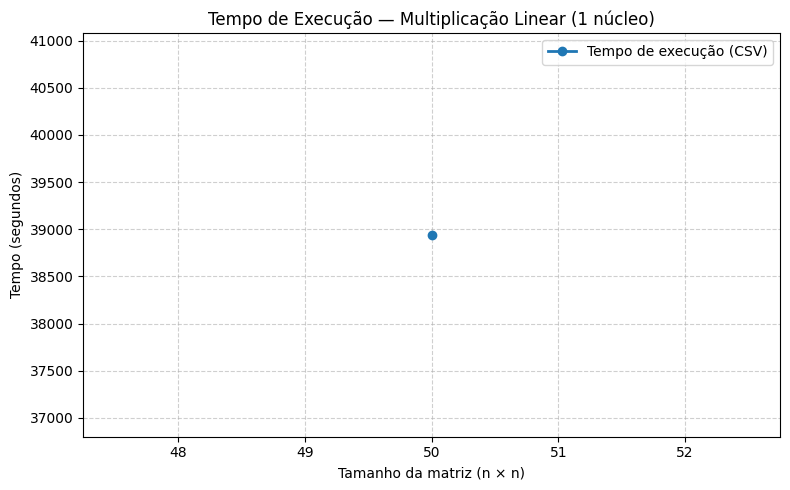

In [271]:
def plot_linear(df: pd.DataFrame):
    """Plota tempo × tamanho_n para modo linear (1 núcleo)."""
    df_lin = df[df["modo"] == "linear"].copy()
    if df_lin.empty:
        raise ValueError("Não há linhas do modo 'linear' no CSV. Rode o linear ou verifique o arquivo.")

    df_lin = df_lin.dropna(subset=["tempo_clock"]).sort_values("timestamp").reset_index(drop=True)

    if "tamanho_n" not in df_lin.columns:
        template_sizes = [50, 75, 100, 125, 150, 200, 250, 300, 400, 500]
        if len(df_lin) > len(template_sizes):
            template_sizes = list(range(50, 50*(len(df_lin)+1), 50))
        df_lin["tamanho_n"] = template_sizes[:len(df_lin)]

    df_lin["tamanho_n"] = pd.to_numeric(df_lin["tamanho_n"], errors="coerce")
    df_lin = df_lin.dropna(subset=["tamanho_n"]).sort_values("tamanho_n")

    plt.figure(figsize=(8,5))
    plt.plot(
        df_lin["tamanho_n"], df_lin["tempo_clock"],
        marker="o", linewidth=2, label="Tempo de execução (CSV)"
    )
    plt.title("Tempo de Execução — Multiplicação Linear (1 núcleo)")
    plt.xlabel("Tamanho da matriz (n × n)")
    plt.ylabel("Tempo (segundos)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_linear(df)

In [272]:
def plot_por_processos(df: pd.DataFrame, modo: str, titulo: str):
    """Plota tempo × num_processos para um modo específico."""
    dff = df[df["modo"] == modo].copy()
    if dff.empty:
        print(f"Aviso: não há linhas com modo '{modo}'.")
        return
    dff = dff.dropna(subset=["num_processos","tempo_clock"]).sort_values("num_processos")

    plt.figure(figsize=(8,5))
    plt.plot(
        dff["num_processos"], dff["tempo_clock"],
        marker="o", linewidth=2, label="Tempo de execução (segundos)"
    )
    plt.title(titulo)
    plt.xlabel("Número de núcleos (processos)")
    plt.ylabel("Tempo de execução (segundos)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

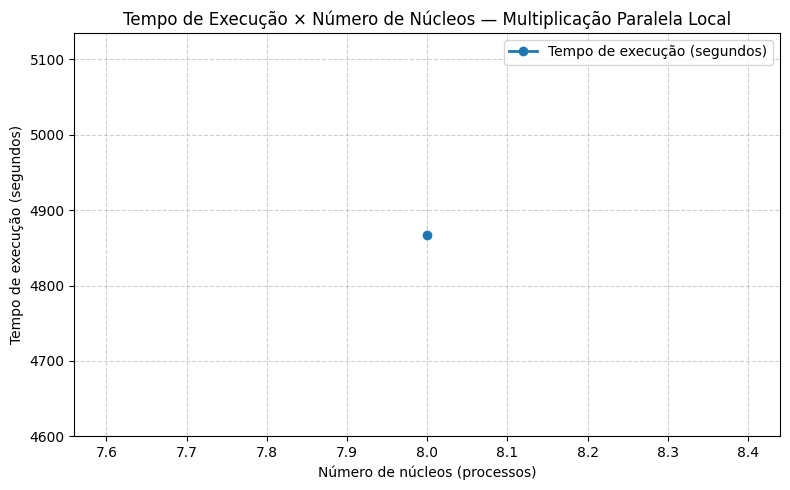

In [273]:
plot_por_processos(
    df, modo="paralelo_local",
    titulo="Tempo de Execução × Número de Núcleos — Multiplicação Paralela Local"
)

In [274]:
plot_por_processos(df, modo="distribuida",
                   titulo="Tempo de Execução × Número de Núcleos — Multiplicação Distribuída")

Aviso: não há linhas com modo 'distribuida'.


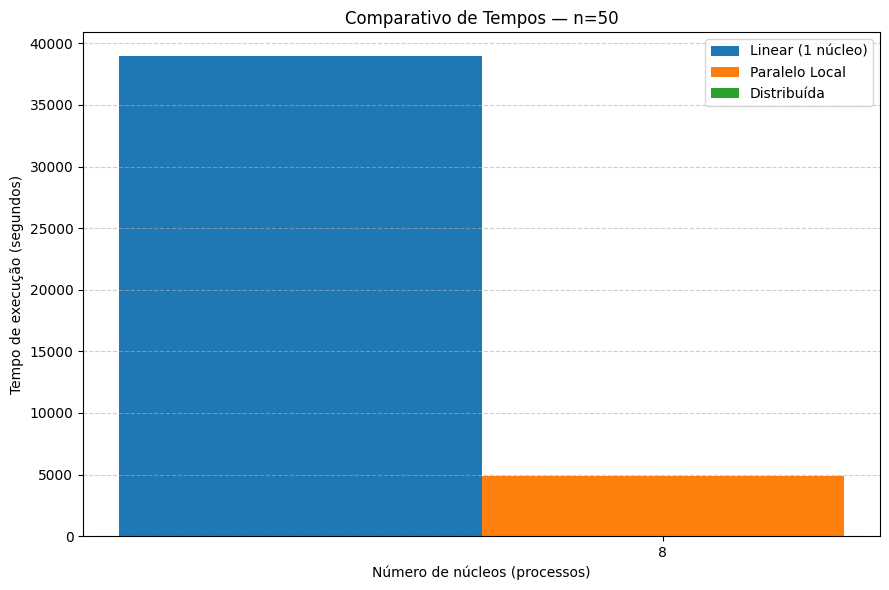

In [275]:
def plot_comparativo_barras(df: pd.DataFrame):

    lin = df[df["modo"] == "linear"].copy()
    if lin.empty:
        print("Aviso: sem 'linear' para comparativo.")
        return

    lin = lin.dropna(subset=["tempo_clock"]).sort_values("timestamp").reset_index(drop=True)
    if "tamanho_n" not in lin.columns:
        lin["tamanho_n"] = np.arange(50, 50*(len(lin)+1), 50)[:len(lin)]
    lin["tamanho_n"] = pd.to_numeric(lin["tamanho_n"], errors="coerce")
    lin = lin.dropna(subset=["tamanho_n"]).sort_values("tamanho_n")
    n_ref = int(lin["tamanho_n"].max())
    t_lin = float(lin.loc[lin["tamanho_n"].eq(n_ref), "tempo_clock"].iloc[-1])

    par = df[df["modo"] == "paralelo_local"][["num_processos","tempo_clock"]].dropna()
    dist = df[df["modo"] == "distribuida"][["num_processos","tempo_clock"]].dropna()

    par = par.sort_values("num_processos").drop_duplicates("num_processos", keep="last")
    dist = dist.sort_values("num_processos").drop_duplicates("num_processos", keep="last")

    procs = sorted(set(par["num_processos"]) | set(dist["num_processos"]))
    if not procs:
        print("Aviso: não há processos em 'paralelo_local' ou 'distribuida' para comparar.")
        return

    cmp_df = pd.DataFrame({"num_processos": procs})
    cmp_df["linear"] = t_lin
    cmp_df["paralelo_local"] = cmp_df["num_processos"].map(par.set_index("num_processos")["tempo_clock"])
    cmp_df["distribuida"]   = cmp_df["num_processos"].map(dist.set_index("num_processos")["tempo_clock"])

    x = np.arange(len(cmp_df))
    w = 0.28
    plt.figure(figsize=(9,6))
    plt.bar(x - w, cmp_df["linear"],          width=w, label="Linear (1 núcleo)")
    plt.bar(x,      cmp_df["paralelo_local"], width=w, label="Paralelo Local")
    plt.bar(x + w,  cmp_df["distribuida"],    width=w, label="Distribuída")
    plt.xticks(x, cmp_df["num_processos"].astype(int))
    plt.xlabel("Número de núcleos (processos)")
    plt.ylabel("Tempo de execução (segundos)")
    plt.title(f"Comparativo de Tempos — n={n_ref}")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_comparativo_barras(df)

Gráfico comparativo entre o tempo (em segundos) e a multiplicação paralela distribuída (múltiplos núcleos em 2 backends); 


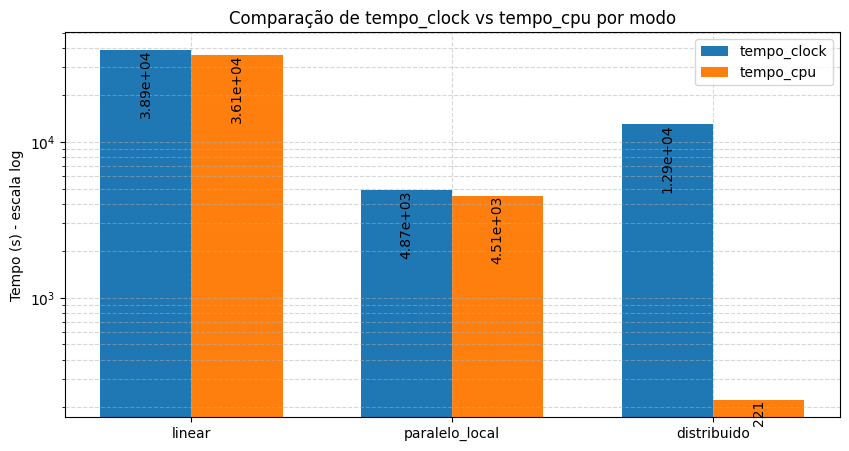

In [276]:
modes = df['modo'].astype(str).tolist()
tempo_clock = df['tempo_clock'].astype(float).tolist()
tempo_cpu = df['tempo_cpu'].astype(float).tolist()

x = list(range(len(modes)))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar([xi - width/2 for xi in x], tempo_clock, width=width, label='tempo_clock', color='C0')
plt.bar([xi + width/2 for xi in x], tempo_cpu, width=width, label='tempo_cpu', color='C1')

plt.xticks(x, modes)
plt.yscale('log')
plt.ylabel("Tempo (s) - escala log")
plt.title("Comparação de tempo_clock vs tempo_cpu por modo")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)

for xi, tc, tp in zip(x, tempo_clock, tempo_cpu):
    plt.text(xi - width/2, tc if tc>0 else 1e-12, f"{tc:.3g}", ha='center', va='top', fontsize=10, rotation=90)
    plt.text(xi + width/2, tp if tp>0 else 1e-12, f"{tp:.3g}", ha='center', va='top', fontsize=10, rotation=90)

plt.show()

In [277]:
dfb = pd.read_csv("src/results/benchmarks.csv")

subset = dfb.query("section=='gemm' and dtype=='float64'")
pivot = subset.pivot_table(index="n", values="value", columns="host", aggfunc='first').astype(float)
pivot.plot(kind="bar", figsize=(9,5))
plt.ylabel("GFLOPS (float64)")
plt.title("Benchmark GEMM por host")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

scalar = dfb.query("section=='scalar'")
pivot2 = scalar.pivot_table(index="metric", values="value", columns="host", aggfunc='first').astype(float)
pivot2.plot(kind="bar", figsize=(7,4))
plt.ylabel("Operações por segundo")
plt.title("Benchmark escalar (Python)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

ParserError: Error tokenizing data. C error: Expected 12 fields in line 16, saw 23
